In [215]:
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [8]:
test_path = 'C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/data/'

test_data = pd.read_json(test_path)

In [9]:
#make dataframe of messages
post_messages = test_data['messages']

In [34]:
# new dataframe with columns: username, user_title, post_time, joined, raw_text, clean_text, post_title
post_messages_df = pd.DataFrame(columns=['username', 'user_title', 'post_time', 'user_info', 'raw_text', 'clean_text', 'post_title'])

In [44]:
c = 0
message_df = pd.DataFrame(columns=['username', 'user_title', 'post_time', 'user_info', 'raw_text', 'clean_text', 'post_title'])
for row in test_data.iterrows():
    # print(row)
    for message in row[1]['messages']:
        # print(message)
        # message_df.loc[c] = [message['username'], message['user_title'], message['post_time'], message['joined'], message['raw_text'], message['clean_text'], row[1]['title']]
        message_df.loc[c, 'username'] = message['username']
        message_df.loc[c, 'user_title'] = message['user_title']
        message_df.loc[c, 'post_time'] = message['post_time']
        message_df.loc[c, 'user_info'] = message['joined']
        message_df.loc[c, 'raw_text'] = message['raw_text']
        message_df.loc[c, 'clean_text'] = message['clean_text']
        message_df.loc[c, 'post_title'] = row[1]['title']
        message_df.loc[c, 'post_author'] = row[1]['author']
        message_df.loc[c, 'post_label'] = row[1]['label']
        message_df.loc[c, 'post_time'] = row[1]['time']
        # message_df.loc[c, 'message']
        c += 1

In [102]:
def convertJSON(path):
    c = 0
    json_df = pd.read_json(path)
    df = pd.DataFrame(columns=['username', 'user_title', 'post_time', 'user_info', 'raw_text', 'clean_text', 'post_title'])
    for row in json_df.iterrows():
        k = 0
        for message in row[1]['messages']:
            df.loc[c, 'username'] = message['username']
            df.loc[c, 'user_title'] = message['user_title']
            df.loc[c, 'post_time'] = message['post_time']
            df.loc[c, 'user_info'] = message['joined']
            df.loc[c, 'raw_text'] = message['raw_text']
            df.loc[c, 'clean_text'] = message['clean_text']
            df.loc[c, 'post_title'] = row[1]['title']
            df.loc[c, 'post_author'] = row[1]['author']
            df.loc[c, 'post_label'] = row[1]['label']
            df.loc[c, 'post_time'] = row[1]['time']
            
            if k == 0 and message['username'] == row[1]['author']:
                df.loc[c, 'first_message'] = True
            else:
                df.loc[c, 'first_message'] = False
            c += 1
            k += 1
    
    df['post_time'] = pd.to_datetime(df['post_time'], unit='s')
    
    df['user_info'] = df['user_info'].apply(incel_joined_read)
    df['user_info'] = df['user_info'].apply(list_to_dict)

    df['word_list'] = df['clean_text'].apply(string_to_word_list)
    return df   


In [103]:
def incel_joined_read(string):
    #check if string is actually string
    if not isinstance(string, str):
        return string
    try:
        string = re.sub(r'\n', '|', string)
        string = string.split('|')
        string = [x for x in string if x != '']
        # string = [x for x in string if x != '' and x != 'Messages']
    except:
        string = string
    return string

In [104]:
def list_to_dict(list):
    try:
        length = len(list)
    except:
        return list
    dict = {}
    for i in range(0, length, 2):
        try:
            dict[list[i]] = list[i+1]
        except:
            dict[list[i]] = ''
    
    return dict

In [47]:
message_df['user_info'] = message_df['user_info'].apply(incel_joined_read)
message_df['user_info'] = message_df['user_info'].apply(list_to_dict)

In [39]:
message_df.head()

,username,user_title,post_time,user_info,raw_text,clean_text,post_title,post_author,post_label
0,SergeantIncel,Admincel,1538414660,"{'Joined': 'Nov 7, 2017', 'Messages': '1,648'}",List of useful links:\n\nRules & FAQ\nIntroduc...,\nList of useful links:\n\nRules & FAQ\nIntrod...,Useful Links,SergeantIncel,NaN
1,MaxZM98,Socially constructed loser,1539783513,"{'Joined': 'May 2, 2018', 'Posts': '3,701', 'O...",I was looking at myself in the gym mirror and ...,\nI was looking at myself in the gym mirror an...,My arms are so small,MaxZM98,[SuicideFuel]
2,itsmemario,Banned,1539783513,"{'Joined': 'Sep 24, 2018', 'Posts': '581', 'On...","You, have a shitty training plan or shitty mea...","\nYou, have a shitty training plan or shitty m...",My arms are so small,MaxZM98,[SuicideFuel]
3,3uxp,Captain,1539783513,"{'Joined': 'Mar 9, 2018', 'Posts': '1,622', 'O...","I bet you're white, huge muscles and big arms ...","\nI bet you're white, huge muscles and big arm...",My arms are so small,MaxZM98,[SuicideFuel]
4,Hunter,Banned,1539783513,"{'Joined': 'Nov 28, 2017', 'Posts': '13,365', ...","@MaxZM98 \n\nNoFap, now!","\n@MaxZM98 \n\nNoFap, now!",My arms are so small,MaxZM98,[SuicideFuel]


In [16]:
message_df['lifetime message total'] = message_df['joined'].apply(lambda x: x[-1])

In [105]:
data_folder = 'C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/data/'

df_1 = convertJSON(data_folder + '20181017133526_main.json')

In [53]:
df_1.to_csv('C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/data/20181017133526_main.csv')

In [59]:
csv_folder = 'C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/messages/'
df_csv = pd.read_csv(csv_folder + '20181017133526_main.csv', index_col=0)

In [99]:
def string_to_word_list(string):
    if not isinstance(string, str):
        string = str(string)
    string = string.lower()
    string = re.sub(r'[^a-z0-9 ]', '', string)
    string = string.split(' ')
    string = [x for x in string if x != '']
    return string

In [64]:
df_1['word_list'] = df_1['clean_text'].apply(string_to_word_list)

In [106]:
df_1.head()

,username,user_title,post_time,user_info,raw_text,clean_text,post_title,post_author,post_label,first_message,word_list
0,SergeantIncel,Admincel,2018-10-01 17:24:20,"{'Joined': 'Nov 7, 2017', 'Messages': '1,648'}",List of useful links:\n\nRules & FAQ\nIntroduc...,\nList of useful links:\n\nRules & FAQ\nIntrod...,Useful Links,SergeantIncel,NaN,True,"[list, of, useful, linksrules, faqintroduction..."
1,MaxZM98,Socially constructed loser,2018-10-17 13:38:33,"{'Joined': 'May 2, 2018', 'Posts': '3,701', 'O...",I was looking at myself in the gym mirror and ...,\nI was looking at myself in the gym mirror an...,My arms are so small,MaxZM98,[SuicideFuel],True,"[i, was, looking, at, myself, in, the, gym, mi..."
2,itsmemario,Banned,2018-10-17 13:38:33,"{'Joined': 'Sep 24, 2018', 'Posts': '581', 'On...","You, have a shitty training plan or shitty mea...","\nYou, have a shitty training plan or shitty m...",My arms are so small,MaxZM98,[SuicideFuel],False,"[you, have, a, shitty, training, plan, or, shi..."
3,3uxp,Captain,2018-10-17 13:38:33,"{'Joined': 'Mar 9, 2018', 'Posts': '1,622', 'O...","I bet you're white, huge muscles and big arms ...","\nI bet you're white, huge muscles and big arm...",My arms are so small,MaxZM98,[SuicideFuel],False,"[i, bet, youre, white, huge, muscles, and, big..."
4,Hunter,Banned,2018-10-17 13:38:33,"{'Joined': 'Nov 28, 2017', 'Posts': '13,365', ...","@MaxZM98 \n\nNoFap, now!","\n@MaxZM98 \n\nNoFap, now!",My arms are so small,MaxZM98,[SuicideFuel],False,"[maxzm98, nofap, now]"


In [107]:
df_first_message = df_1[df_1['first_message'] == True]

In [108]:
df_first_message.head()

,username,user_title,post_time,user_info,raw_text,clean_text,post_title,post_author,post_label,first_message,word_list
0,SergeantIncel,Admincel,2018-10-01 17:24:20,"{'Joined': 'Nov 7, 2017', 'Messages': '1,648'}",List of useful links:\n\nRules & FAQ\nIntroduc...,\nList of useful links:\n\nRules & FAQ\nIntrod...,Useful Links,SergeantIncel,NaN,True,"[list, of, useful, linksrules, faqintroduction..."
1,MaxZM98,Socially constructed loser,2018-10-17 13:38:33,"{'Joined': 'May 2, 2018', 'Posts': '3,701', 'O...",I was looking at myself in the gym mirror and ...,\nI was looking at myself in the gym mirror an...,My arms are so small,MaxZM98,[SuicideFuel],True,"[i, was, looking, at, myself, in, the, gym, mi..."
17,SchrodingersDick,Skeleton Volume = Life Quality,2018-10-16 01:46:42,"{'Joined': 'Aug 7, 2018', 'Posts': '8,033', 'O...",If there any sperm banks that disclose the man...,\nIf there any sperm banks that disclose the m...,Getting 6’7” aryan gigachad to sneak a 5’2” et...,SchrodingersDick,[Experiment],True,"[if, there, any, sperm, banks, that, disclose,..."
57,rabitter,Incel Blanquist,2018-10-17 09:22:55,"{'Joined': 'Mar 12, 2018', 'Messages': '3,453'}",The fact that a man like this exists is unfilt...,\nThe fact that a man like this exists is unfi...,7'2 Giga Chad - The Man Who Mogs Every Human i...,rabitter,[SuicideFuel],True,"[the, fact, that, a, man, like, this, exists, ..."
120,Doug,Officer,2018-10-17 07:52:30,"{'Joined': 'Jun 16, 2018', 'Messages': '710'}","If you beat him up, you gonna get smacked by h...","\nIf you beat him up, you gonna get smacked by...",There's no way winning against your schoolbull...,Doug,[Venting],True,"[if, you, beat, him, up, you, gonna, get, smac..."


In [109]:
# only keep first messages that are longer than 10 words
df_first_message = df_first_message[df_first_message['word_list'].apply(len) > 10]

In [110]:
df_sample = df_first_message.sample(n=20)
df_sample.head()

,username,user_title,post_time,user_info,raw_text,clean_text,post_title,post_author,post_label,first_message,word_list
19338,thespanishcel,Commander,2018-11-30 19:14:39,"{'Joined': 'May 13, 2018', 'Posts': '3,318', '...",He just wanted to talk about Mad Max yet 4chan...,\nHe just wanted to talk about Mad Max yet 4ch...,Handcel gets mocked in 4chan,thespanishcel,None,True,"[he, just, wanted, to, talk, about, mad, max, ..."
8830,copecel2,Recruit,2018-11-19 02:27:25,"{'Joined': 'Apr 12, 2018', 'Messages': '53'}",Idiots and cucks do not even deserve this term...,\nIdiots and cucks do not even deserve this te...,Bluepill is an euphemism used for retards,copecel2,None,True,"[idiots, and, cucks, do, not, even, deserve, t..."
4531,Reddit_is_for_cucks,Overlord,2018-10-17 04:35:02,"{'Joined': 'Nov 10, 2017', 'Posts': '8,067', '...",Can you imagine how much pussy this guy gets??...,\nCan you imagine how much pussy this guy gets...,Girls are going crazy over this latest chad th...,Reddit_is_for_cucks,[RageFuel],True,"[can, you, imagine, how, much, pussy, this, gu..."
18911,AntiPain,Veteran,2018-12-01 18:12:03,"{'Joined': 'Jun 7, 2018', 'Messages': '1,308'}","It always comes back to me. The memories, the ...","\nIt always comes back to me. The memories, th...",Missing your childhood and merely experiencing...,AntiPain,[SuicideFuel],True,"[it, always, comes, back, to, me, the, memorie..."
7910,EthnicelNL,Never began tbhtbh,2018-10-18 17:26:25,"{'Joined': 'May 2, 2018', 'Messages': '9,194'}",Just watched this classic movie for the first ...,\nJust watched this classic movie for the firs...,(Movie) Lawrence of Arabia brutal JBWpill from...,EthnicelNL,[SuicideFuel],True,"[just, watched, this, classic, movie, for, the..."


In [111]:
df_sample.to_excel('C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/messages/20181017133526_main_sample.xlsx')

In [115]:
response_1 = pd.read_csv('C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/responses/response_1.csv', index_col=0)
response_2 = pd.read_csv('C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/responses/response_2.csv', index_col=0)
response_3 = pd.read_csv('C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/responses/response_3.csv', index_col=0)

In [119]:
# DONT_KNOW = 1
# DEFEATED = 2
# NOTCONFIDENT = 4
# REJECTED = 8
# CONFUSED = 16
# SAD = 32
# INSECURE = 64
# FEARFUL = 128
# FRUSTRATED = 256
# EXCLUDED = 512
# WEAK = 1024
# SCORNED = 2048
# SHUNNED = 4096
# UNATTRACTIVE = 8192
# HATEFUL = 16384
# DISGUSTED = 32768
# PARANOID = 65536
# RESENTFUL = 131072
# VENGEFUL = 262144
# ENRAGED = 524288
# VIOLENT = 1048576

# value_dict = {
#     'DEFEATED': DEFEATED,
#     'NOTCONFIDENT': NOTCONFIDENT,
#     'REJECTED': REJECTED,
#     'CONFUSED': CONFUSED,
#     'SAD': SAD,
#     'INSECURE': INSECURE,
#     'FEARFUL': FEARFUL,
#     'FRUSTRATED': FRUSTRATED,
#     'EXCLUDED': EXCLUDED,
#     'WEAK': WEAK,
#     'SCORNED': SCORNED,
#     'SHUNNED': SHUNNED,
#     'UNATTRACTIVE': UNATTRACTIVE,
#     'HATEFUL': HATEFUL,
#     'DISGUSTED': DISGUSTED,
#     'PARANOID': PARANOID,
#     'RESENTFUL': RESENTFUL,
#     'VENGEFUL': VENGEFUL,
#     'ENRAGED': ENRAGED,
#     'VIOLENT': VIOLENT,
#     'DONT_KNOW': DONT_KNOW
# }

In [128]:
from enum import Enum, auto, IntFlag

class incel_trait(IntFlag):
    DONT_KNOW = auto()
    DEFEATED = auto()
    NOTCONFIDENT = auto()
    REJECTED = auto()
    CONFUSED = auto()
    SAD = auto()
    INSECURE = auto()
    FEARFUL = auto()
    FRUSTRATED = auto()
    EXCLUDED = auto()
    WEAK = auto()
    SCORNED = auto()
    SHUNNED = auto()
    UNATTRACTIVE = auto()
    HATEFUL = auto()
    DISGUSTED = auto()
    PARANOID = auto()
    RESENTFUL = auto()
    VENGEFUL = auto()
    ENRAGED = auto()
    VIOLENT = auto()

In [136]:
print('Defeated'.upper() in incel_trait.__members__)

True


In [143]:
test_list = ['defeated', 'notconfident']
print(list_to_incel_traits(test_list))

incel_trait.NOTCONFIDENT|DEFEATED


In [206]:
def list_to_incel_traits(trait_list):
    trait_bits = 0
    if isinstance(trait_list, str):
        trait_list = str.split(trait_list, ',')
    for trait in trait_list:
        print(trait)
        if trait.lower() == 'not confident':
            trait = 'notconfident'
            print(trait)
        elif trait.lower() == 'i do not know':
            trait = 'dont_know'
            print(trait)
        else:
            trait = trait.replace(' ','').lower()

        if trait.upper() in incel_trait.__members__:
            trait_bits += incel_trait[trait.upper()].value
            print(trait_bits)

    return incel_trait(trait_bits)

In [207]:
all_responses = pd.read_csv('C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/responses/all_responses.csv', index_col=0)

#rename column 18886 to 18686
all_responses.rename(columns={'18886': '18686'}, inplace=True)
all_responses.rename(columns={'18886.1': '18886'}, inplace=True)

In [208]:
#convert each column to incel_traits
for col in all_responses.columns:
    all_responses[col] = all_responses[col].apply(list_to_incel_traits)

Insecure
64
 Scorned
2112
 Disgusted
34880
Rejected
8
 Insecure
72
 Excluded
584
 Shunned
4680
 Unattractive
12872
Excluded
512
 Scorned
2560
 Resentful
133632
Disgusted
32768
 Resentful
163840
Fearful
128
 Frustrated
384
 Scorned
2432
 Hateful
18816
 Paranoid
84352
 Vengeful
346496
 Enraged
870784
Hateful
16384
 Disgusted
49152
 Resentful
180224
Not Confident
notconfident
4
 Insecure
68
 Frustrated
324
 Resentful
131396
Not Confident
notconfident
4
 Insecure
68
 Frustrated
324
 Scorned
2372
 Hateful
18756
 Disgusted
51524
 Resentful
182596
 Enraged
706884
Rejected
8
 Insecure
72
 Frustrated
328
 Unattractive
8520
Defeated
2
 Not Confident
6
 Rejected
14
 Sad
46
 Insecure
110
 Fearful
238
 Frustrated
494
 Weak
1518
Defeated
2
 Not Confident
6
 Sad
38
 Insecure
102
 Frustrated
358
 Weak
1382
 Hateful
17766
 Disgusted
50534
Defeated
2
 Not Confident
6
 Rejected
14
 Sad
46
 Insecure
110
 Frustrated
366
 Excluded
878
Hateful
16384
 Disgusted
49152
Rejected
8
 Insecure
72
 Fearful
200
 Frus

In [209]:
#reindex from 0
all_responses = all_responses.reset_index(drop=True)

In [259]:
all_responses.to_csv('C:/Users/Zacha/repo/HomeworkNotebooks/data/incel_data/responses/all_responses_incel_traits.csv')

In [251]:
df_ins = all_responses.copy()

for col in df_ins.columns:
    for row in df_ins.index:
        traits = incel_trait(df_ins[col][row])
        if incel_trait.INSECURE in traits:
            df_ins[col][row] = incel_trait.INSECURE
        else:
            df_ins[col][row] = 0

ins_vectors = []
for row in df_ins.iterrows():
    ins_vectors.append(row[1])

ins_vectors = np.array(ins_vectors)

ins_anno = AnnotationsContainer.from_array(ins_vectors)


In [252]:
ins_anno.labels

[0, 64]

In [254]:
pyanno.measures.agreement.labels_frequency(ins_anno.annotations, 4)

array([0.39215686, 0.60784314, 0.        , 0.        ])

In [214]:
# vector_1 = all_responses.iloc[0]
# vector_2 = all_responses.iloc[1]
vectors = []
for row in all_responses.iterrows():
    vectors.append(row[1])

# create array of vectors
vectors = np.array(vectors)
vectors

array([[  34880,  163840,  131396,    1518,   49152,   10088,      68,
              1,  131152,  180224,     162,     750,   16384,  147456,
           9446,  672000,  131432],
       [  12872,  870784,  706884,   50534,  152520,  194542,    9316,
         139584,       1,  943436,    9710,  156012,       1,  714436,
         194414,  975688,  189292],
       [ 133632,  180224,    8520,     878,   34632,  143630,       1,
            592,   33280,  484160,    4832,    2370,   16384,  174592,
           9568, 1591296,    4616]], dtype=int64)

In [223]:
anno = AnnotationsContainer.from_array(vectors, missing_values=[incel_trait.DONT_KNOW.value])

In [226]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.04255319, 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.04255319, 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ,
       0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 , 0.0212766 ])

[[1. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


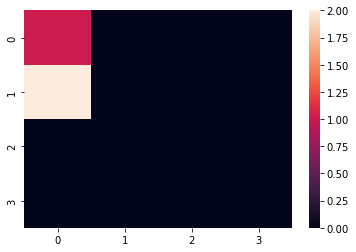

In [258]:
c = pyanno.measures.agreement.confusion_matrix(ins_anno.annotations[:,0], ins_anno.annotations[:,1], 4)
print(c)
ac = seaborn.heatmap(c)
plt.show()